<a href="https://colab.research.google.com/github/Bhavya-2k03/RealTimeSurgicalSkillClassification/blob/main/3d_CNN_final_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random #To pick random frames from the video
import numpy as np#To pad frames which are different in shape from others 
import cv2#To capture frames from video & for basic image operation
import os#To do file related operations
import tensorflow as tf#To bulid and interact with our model
import matplotlib.pyplot as plt #To to visualize results 
import seaborn as sn #To plot confusion Matrix
from tensorflow.keras.models import Model #To make a custom model 
from tensorflow.keras.layers import Conv3D,Dense,Flatten,Average,Input#To Build architecture of model
from keras.utils import to_categorical,plot_model #to_categorical for converting integral labels to one hot encoded vector,plot_model to visualize our model
from keras.models import load_model# to save model(including weights)
from sklearn.metrics import roc_auc_score,roc_curve, auc,precision_score,f1_score,accuracy_score,recall_score #To Judge model performance on various classification metrics 
from itertools import cycle#To handle iterators

In [ ]:
!gdown --id 1wPY8-7X-Na8uvx2xl6djEPuWSUBzs582 #Knot Tying Dataset
!gdown --id 1WNv_QmjHmfE_6FgM5IF0nf7IYN8fWGaL #Needle passing Dataset
!gdown --id 1ISAcB536gTKuvqgwr7us4_oO6klNKlIl #Suturing Dataset

In [ ]:
!gdown --id 1NmoNgShgFu7qferhVDY8oMu3gNrIR9oZ #Knot tying weights 
!gdown --id 1--tlGD_qXqqntwnet0rmIwB1nTwtdX8R #Needle passing weights
!gdown --id 1pbb0Gv0nQbGj9tGcOPEvoUuz_ATMEMVZ #Suturing weights

In [ ]:
!unzip Knot_Tying.zip #unzipping Knot_Tying dataset file
!unzip Suturing.zip #unzipping Suturing dataset file
!unzip Needle_Passing.zip #unzipping Needle_Passing dataset file

In [ ]:
surgery_type=''
task=int(input("Press 1 for knot tying, Press 2 for suturing, Press 3 for Needle Passing: \n"))
if task ==1:
    surgery_type='Knot_Tying'
    model=load_model('/content/knot_tying.h5') #loading pretrained model
elif task ==2:
    surgery_type='Suturing'
    model=load_model('/content/suturing.h5') #loading pretrained model
elif task ==3:
    surgery_type='Needle_Passing'
    model=load_model('/content/needle_passing.h5') #loading pretrained model

Press 1 for knot tying, Press 2 for suturing, Press 3 for Needle Passing: 
1


In [ ]:
surgery_name=[] #initialising list named surgery_name
expertise_level=[]

def getMetaDataForSurgeries(surgery_type): #getting skill level of surgeons for a different surgical videos (for training)
	surgeries_metadata = {} 
	file = open(surgery_type+'/'+'meta_file_'+surgery_type+'.txt','r') 
	for line in file: 
		line = line.strip() 
		if len(line)==0: 
			break
		b = line.split()
		surgery_name.append(b[0]) #adding name of surgery in surgery name list
		expertise_level.append(b[1]) #adding corresponding skill level of the surgeon 

In [ ]:
getMetaDataForSurgeries(surgery_type) #calling the function

In [ ]:
# from sklearn import preprocessing
# le=preprocessing.LabelEncoder()
# integral_level2=le.fit_transform(expertise_level)

In [ ]:
integral_level=[]
for i in expertise_level:  #converting string labels to integral labels  
    if i=="N":
        integral_level.append(0)
    elif i=="I":
        integral_level.append(1)
    elif i=="E":
        integral_level.append(2)
        
encoded=to_categorical(integral_level) #converting integral labels to one hot encoded vector

In [ ]:
inputAlist=[]
inputBlist=[]
inputClist=[]
inputDlist=[]

In [ ]:
print(len(surgery_name))

36


In [ ]:
for i in surgery_name: # randomly choosing 90 frames from the video and appending them in a list
    vid=cv2.VideoCapture(f"/content/{surgery_type}/video/{i}_capture1.avi")
    total_length=int(vid.get(cv2.CAP_PROP_FRAME_COUNT)) #total frames in the video
    
    random_number_A=np.random.randint(0,(total_length-90))
    numbers_A=[i for i in range(random_number_A,random_number_A+90)] #generating 90 continuous random numbers

    count=0
    reg,frame=vid.read() #starting to read the video

    while True:
        if count in numbers_A: 
                inputAlist.append(frame) #appending the frames in the list "inputAlist"

        elif count>total_length :
            break

        count=count+1

In [ ]:
pad_list=[]  #finding frames whose shapes are different from previous frames
for i in range(0,len(inputAlist)):
    if i!=0:
        if inputAlist[i].shape != inputAlist[i-1].shape:
            pad_list.append(i) #appending those frames to a list

In [ ]:
def pad(input,x,y): #function to pad the frames ( i.e to make shapes of all frames equal)
    for i in range(x,y):
        img = input[i]
        old_image_height, old_image_width, channels = img.shape
        new_image_width = 640 #desired width
        new_image_height = 480 #desired height
        color = (255,0,0) #color to pad with (here, its blue)
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2
        result[y_center:y_center+old_image_height,x_center:x_center+old_image_width] = img
        input[i]=result

In [ ]:
pad(inputAlist,pad_list[0],pad_list[1]) #calling the function to pad the frames
if surgery_type=='Needle_Passing':
    pad(inputAlist,pad_list[2],pad_list[3]) #calling the function to pad the frames

In [ ]:
npinput_A=np.array(inputAlist) #converting list containing frames to array (so that we can reshape it according to our model)

In [ ]:
if task ==1: #reshaping the array
    npinput_reshapedA=npinput_A.reshape(36,90,480,640,3)
elif task ==2:
    npinput_reshapedA=npinput_A.reshape(39,90,480,640,3)
elif task ==3:
    npinput_reshapedA=npinput_A.reshape(28,90,480,640,3)

In [ ]:
#Building the model
inputA=Input(shape=(90,480,640,3))  #defining the input layer 
w=Conv3D(32,(3,3,3), activation='relu')(inputA) #using Conv3d so that model temporal information can be extracted 
w=Flatten()(w) #flatting the feature map obtained from Convolution layers
output=Dense(3,activation="softmax")(w) #finally a dense layer with softmax activation to give final prediction 
model=Model(inputs=inputA, outputs=output) #defining inputs and outputs of model
model.summary() #printing summary of the model

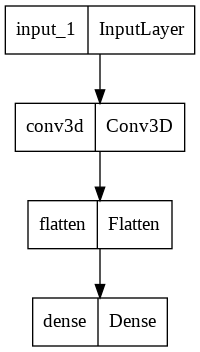

In [ ]:
plot_model(model) #visualizing the model

In [ ]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False),
              metrics=['accuracy']) #compiling the model, adam cause most of the time it performs well in multiclass classification (learning rate is by deafult kept as 0.01)

In [ ]:
model.fit(npinput_reshapedA[:int(len(encoded)*0.7)],encoded[:int(len(encoded)*0.7)],batch_size=1,epochs=10,verbose=1) #training on 70 % of the videos

Epoch 1/10
19/19 [==============================] - 8s 415ms/step - loss: 2485.0383 - accuracy: 0.6842
Epoch 2/10
19/19 [==============================] - 8s 419ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
19/19 [==============================] - 8s 417ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
19/19 [==============================] - 8s 414ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
19/19 [==============================] - 8s 410ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
19/19 [==============================] - 8s 407ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
19/19 [==============================] - 8s 405ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
19/19 [==============================] - 8s 405ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
19/19 [==============================] - 8s 405ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
19/19 [==============================] - 8s 406ms/ste

In [ ]:
p=model.predict(npinput_reshapedA,verbose=1,batch_size=1) #Getting prediction from the model

36/36 [==============================] - 11s 91ms/step


In [ ]:
predicted_index=[]
predicted_skill=[]
for i in p:
    temp=np.argmax(i) #returns the index with max value
    predicted_index.append(temp)
    if temp == 0:
        predicted_skill.append("N")
    elif temp ==1:
        predicted_skill.append("I")
    elif temp ==2:
        predicted_skill.append("E")
for x, y in zip(predicted_skill,expertise_level):
    print("Predicted skill level: ",x)
    print("True skill level: ",y)
    print(" ")


Predicted skill level:  N
True skill level:  N
 
Predicted skill level:  N
True skill level:  N
 
Predicted skill level:  N
True skill level:  N
 
Predicted skill level:  N
True skill level:  N
 
Predicted skill level:  I
True skill level:  I
 
Predicted skill level:  I
True skill level:  I
 
Predicted skill level:  I
True skill level:  I
 
Predicted skill level:  I
True skill level:  I
 
Predicted skill level:  I
True skill level:  I
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  E
True skill level:  E
 
Predicted skill level:  I
True skill level:  I
 
Predicted skill leve

In [ ]:
print("Accuracy: ",accuracy_score(expertise_level,predicted_skill)) # gives accuracy
print("Precision: ",precision_score(expertise_level,predicted_skill, average='weighted')) #gives precision 
print("F1 score: ",f1_score(expertise_level,predicted_skill, average='weighted')) #gives F1 score
print("Recall score: ",recall_score(expertise_level,predicted_skill,average="weighted")) #gives Recall score

Accuracy:  0.9722222222222222
Precision:  0.9747474747474748
F1 score:  0.9724355692097628
Recall score:  0.9722222222222222


In [ ]:
n_classes=3
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(encoded[:, i], p[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

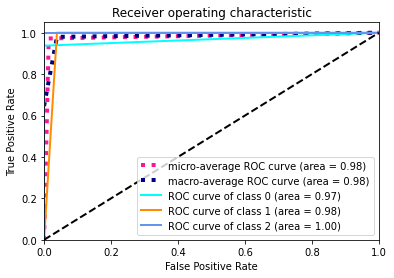

<Figure size 1008x1296 with 0 Axes>

In [ ]:
%matplotlib inline
fpr["micro"], tpr["micro"], _ = roc_curve(encoded.ravel(), p.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw=2
#Aggregating all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Interpolating all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally averaging it and computing AUC 
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Ploting all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.figure(figsize=(14,18))
plt.show()

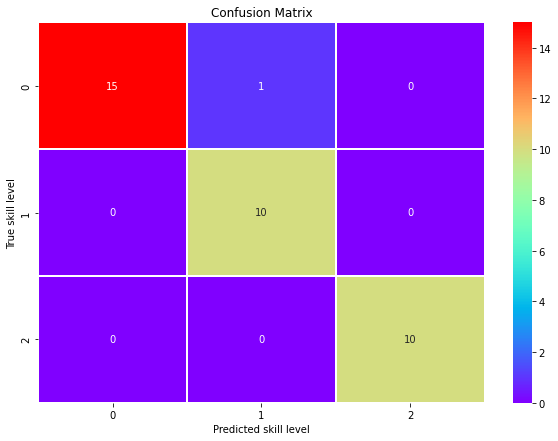

In [ ]:
%matplotlib inline
#plotting confusion matrix
cm=tf.math.confusion_matrix(integral_level,predicted_index,3) 
plt.figure(figsize=(10,7)) 
hm=sn.heatmap(cm,annot=True,fmt='d',cmap="rainbow",linewidths=1) #using heatmap for better visualization
plt.xlabel('Predicted skill level')
plt.ylabel('True skill level')
plt.title("Confusion Matrix")
plt.show()